In [96]:
import os
# import sys  ## (for CLI args) or import argparse
import numpy as np
import itertools
from PIL import Image
from natsort import natsorted
from morph import *
from conn import *

In [72]:
MEDIUM = './data/medium/'
HARD = './data/hard/'
TRUTH = 'ground truth/'

args = ['baseline.py', EASY, '1']
arr = np.array([[1,2,3],[4,5,6],[7,8,9]])

# Baseline Algorithm

Input: intensity video (path to parent directory), number of neurons (n)

Algorithm:

1. Scale intensity video to mean 0, unit variance
2. Threshold intensity at 1
3. Take the n largest components
3. Save result as solution

Output: solution in the parent directory of the intensity video

In [86]:
def load_video(path): 
    ## Load PNGs in path as array
    #
    ## Input
    #    path: String, path to directory that contains videos as a collection of PNGs
    ## Output
    #    A Numpy array containing each frame as a numpy image
    #
    ## Note:
    #    Border cropping hardcoded to match given data.
    #    Rows 40-199 & Columns 114-273 contain the image.
    #    Index by [40:200, 114:274]
    #
    ## TODO: Automate border cropping
    
    return np.array([
        np.asarray(Image.open(path+file))[40:200,114:274] \
         for file in natsorted(os.listdir(path)) \
         if file.endswith('.png')
    ])


def load_solutions(path): 
    ## Load PNGs in path as array
    #
    ## Input
    #    path: String, path to directory that contains videos as a collection of PNGs
    ## Output
    #    A Numpy array containing each frame as a numpy image
    
    return np.array([
        np.asarray(Image.open(path+file)) \
         for file in natsorted(os.listdir(path)) \
         if file.endswith('.png')
    ])


def scale(arr):
    ## Scales all values in 2D array to 
    #  remove mean and scale to unit variance.
    #
    ## Input: 
    #   arr: 2D array
    ## Output:
    #   Input normalized to mean 0 & std dev 1
    
    return (arr - np.mean(arr)) / np.std(arr)


def sumChannels(img):
    ## Convert image with multiple channels into one channel 
    #  (grayscale) by getting the sum of value accross all channels.
    #
    ## Input: 
    #   img: 2D array of pixels, 
    #        which each pixel is an array of multiple channels
    ## Output:
    #   Image converted to grayscale by merging channels
    
    return np.sum(img, axis=2)


def getChannel(img, channel):
    ## Extract one channel in image with multiple channels.
    #
    ## Input: 
    #   img: 2D Numpy array of pixels, 
    #        which each pixel is an array of multiple channels
    #   channel: int
    #       0: Red
    #       1: Green
    #       2: Blue
    ## Output:
    #   Image with channel extracetd
    
    return img[:,:,channel]    
    

def load_intensity(path, threshold=1):
    ## Load intensity images given a path, normalize values
    #  to zero mean and unit variance, convert to binary.
    #
    # Input:
    #    path: path to where the 'intensity' directory is
    #    treshold: threshold convert image to binary
            
    intensity = [scale(sumChannels(img)) >= threshold 
                 for img in load_video(path + 'intensities/')]
    
    return intensity


def save_video(path, video):
    
    print('Saving solution ..')
    
    i = 0
    save_path = os.path.join(path,'solutions/')
    if not os.path.exists(save_path):
        os.mkdir(save_path)
    
    for frame in video:
        i += 1
        Image.fromarray(frame).save(save_path+str(i)+'.png')
        
    print('Solution saved at '+save_path)

In [81]:
def processFrame(intensity, num_cc=1):
    
    return nLargestCC(intensity,num_cc)

In [87]:
def solve(path, num_cc=1, threshold=1):
    
    intensities = load_intensity(path, threshold)
    
    solutions = []
    i = 0
    
    print('')
    print('Starting solve:')
    for intensity in intensities:
        
        i+=1
        solutions.append(processFrame(intensity, num_cc))
        
        if i%5==0:
            print('\tFrame {:2} processed'.format(i))
        
    print('Solve finished!')
    
    print('')
    save_video(path, solutions)

In [6]:
intensities = load_intensity(EASY)

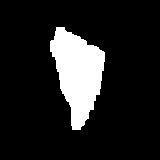

In [7]:
display(Image.fromarray(closing(nLargestCC(opening(intensities[0],4)),1)))

In [28]:
proc = closing(nLargestCC(opening(intensities[0],4)),26)

In [10]:
truth = [sumChannels(img).astype(bool) for img in load_video(EASY+'ground truth/')]

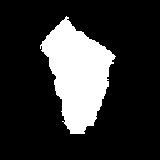

In [12]:
display(Image.fromarray(truth[0]))

In [29]:
np.sum(proc & truth)/np.sum(proc | truth)

0.5272794860073643

In [121]:
solve(HARD, 2)


Starting solve:
	Frame  5 processed
	Frame 10 processed
	Frame 15 processed
	Frame 20 processed
	Frame 25 processed
	Frame 30 processed
Solve finished!

Saving solution ..
Solution saved at ./data/hard/solutions/


In [37]:
solutions = load_solutions(EASY+'solutions/')

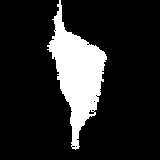

In [39]:
Image.fromarray(solutions[0])

In [47]:
def evaluate(path, k=5):
    
    print('Evaluation:')
    truths = [sumChannels(img).astype(bool) for img in load_video(path+'ground truth/')]
    
    solutions = load_solutions(path+'solutions/')
    
    scores = 0
    
    i=0
    
    for truth, solution in zip(truths, solutions):
        
        i += 1
        scores += (score := np.sum(truth & solution)/np.sum(truth | solution))
        
        if i%k==1:
            print('\tFrame {:2} processed with score {:0.3f}'.format(i, score))
            
            
    print('Average Accuracy: {:0.3f}'.format(scores/len(solutions)))
        

In [77]:
evaluate()

Evaluation:
	Frame  1 processed with score 0.297
	Frame  6 processed with score 0.327
	Frame 11 processed with score 0.327
	Frame 16 processed with score 0.368
	Frame 21 processed with score 0.381
	Frame 26 processed with score 0.356
	Frame 31 processed with score 0.331
Average Accuracy: 0.336


In [65]:
erode(dilate(np.array([
    [1,1,1,1,1,1,1,1,1],
    [1,0,0,0,0,0,0,0,1],
    [1,0,0,0,0,0,0,0,1],
    [1,0,0,0,0,0,0,0,1],
    [1,0,0,0,0,0,0,0,1],
    [1,1,1,1,1,1,1,1,1]
])))

array([[ True,  True,  True,  True,  True,  True,  True,  True,  True],
       [ True, False, False, False, False, False, False, False,  True],
       [ True, False, False, False, False, False, False, False,  True],
       [ True, False, False, False, False, False, False, False,  True],
       [ True, False, False, False, False, False, False, False,  True],
       [ True,  True,  True,  True,  True,  True,  True,  True,  True]])

In [103]:
np.logical_or.reduce([np.logical_and(i, j) for i, j in itertools.combinations(x,2)])

array([[ True,  True],
       [ True,  True]])

In [109]:
import itertools

In [105]:
def foo():
    a = [1,2,3,4,5]
    b = [2,4,6,8,10]
    c = [5,4,3,2,1]
    return a, b, c

In [113]:
bar = foo()

for i in zip(*bar):
    print(list(itertools.combinations(i, 2)))

[(1, 2), (1, 5), (2, 5)]
[(2, 4), (2, 4), (4, 4)]
[(3, 6), (3, 3), (6, 3)]
[(4, 8), (4, 2), (8, 2)]
[(5, 10), (5, 1), (10, 1)]


In [115]:
def foo(a,b,c):
    return a+b+c

x = (1,2,3)

foo(*x)

6

In [116]:
a = np.array([[True, True], [True, False]])
b = np.array([[True, False], [True, False]])
c = np.array([[True, False], [True, True]])
d = np.array([[True, True], [True, True]])
x = [a,b,c,d]

In [118]:
[np.logical_and(*img) for img in itertools.combinations(x,2)]

[array([[ True, False],
        [ True, False]]),
 array([[ True, False],
        [ True, False]]),
 array([[ True,  True],
        [ True, False]]),
 array([[ True, False],
        [ True, False]]),
 array([[ True, False],
        [ True, False]]),
 array([[ True, False],
        [ True,  True]])]

In [175]:
arr = np.array([
    [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1],
    [1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1],
    [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1],
    [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1],
    [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1],
    [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1],
    [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1],
    [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1],
    [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1],
    [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1],
    [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1],
    [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1],
    [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1]
])

arr2 = np.array([
    [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
    [0, 1, 1, 1, 1, 1, 0, 0, 1, 1, 1, 1, 0],
    [0, 1, 1, 1, 1, 1, 0, 0, 1, 1, 1, 1, 0],
    [0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0],
    [0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0],
    [0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0],
    [0, 1, 1, 0, 0, 0, 1, 1, 1, 1, 1, 1, 0],
    [0, 1, 1, 0, 0, 0, 1, 1, 1, 1, 1, 1, 0],
    [0, 1, 1, 0, 0, 0, 1, 1, 1, 1, 1, 1, 0],
    [0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0],
    [0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0],
    [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]
    
])

In [200]:
def dilate(img, n=1):
     
    return np.logical_not(erode(np.logical_not(img), n, padding='edge'))


def opening(img, n=1):

    return dilate(erode(img, n), n)


def closing(img, n=1):
    
    return np.logical_not(opening(np.logical_not(img), n))

In [136]:
def erode(img, n=1):
    
    for _ in range(n):
        img = np.all(np.all(
                np.lib.stride_tricks.sliding_window_view(
                    np.pad(img, 2, mode='constant'), 
                    (3,3)
                )
            ,axis=2),axis=2)
        
    return img[1:-1,1:-1]

erode(arr).astype(int)

array([[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
       [0, 1, 1, 1, 1, 0, 0, 0, 1, 1, 1, 1, 0],
       [0, 1, 1, 1, 1, 0, 0, 0, 1, 1, 1, 1, 0],
       [0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0],
       [0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0],
       [0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0],
       [0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0],
       [0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0],
       [0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0],
       [0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0],
       [0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0],
       [0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0],
       [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]])

In [137]:
dilate(arr2).astype(int)

array([[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1],
       [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1],
       [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1],
       [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1],
       [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1],
       [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1],
       [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1],
       [1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1],
       [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1],
       [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1],
       [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1],
       [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1]])

In [160]:
np.array([
    [np.all(pixel) for pixel in row] 
    for row in np.lib.stride_tricks.sliding_window_view(np.pad(arr2, 1, mode='constant', constant_values=(False,)), (3,3))
]).astype(int) 

array([[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
       [0, 0, 1, 1, 1, 0, 0, 0, 0, 1, 1, 0, 0],
       [0, 0, 1, 1, 1, 0, 0, 0, 0, 1, 1, 0, 0],
       [0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0],
       [0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 0, 0],
       [0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 0, 0],
       [0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 0, 0],
       [0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]])

In [199]:
def erode(img, n=1, padding='constant'):
    for _ in range(n):
        img = np.array([
            [np.all(pixel) for pixel in row] 
            for row \
            in np.lib.stride_tricks.sliding_window_view(
                np.pad(img, 1, mode=padding), 
                (3,3)
            )
        ])
        
    return img

In [201]:
erode(arr).astype(int)

array([[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
       [0, 1, 1, 1, 1, 0, 0, 0, 1, 1, 1, 1, 0],
       [0, 1, 1, 1, 1, 0, 0, 0, 1, 1, 1, 1, 0],
       [0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0],
       [0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0],
       [0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0],
       [0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0],
       [0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0],
       [0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0],
       [0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0],
       [0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0],
       [0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0],
       [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]])

In [202]:
dilate(arr).astype(int)

array([[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1],
       [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1],
       [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1],
       [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1],
       [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1],
       [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1],
       [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1],
       [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1],
       [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1],
       [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1],
       [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1],
       [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1],
       [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1]])

In [203]:
erode(arr2).astype(int)

array([[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
       [0, 0, 1, 1, 1, 0, 0, 0, 0, 1, 1, 0, 0],
       [0, 0, 1, 1, 1, 0, 0, 0, 0, 1, 1, 0, 0],
       [0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0],
       [0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 0, 0],
       [0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 0, 0],
       [0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 0, 0],
       [0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]])

In [204]:
dilate(arr2).astype(int)

array([[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1],
       [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1],
       [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1],
       [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1],
       [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1],
       [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1],
       [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1],
       [1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1],
       [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1],
       [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1],
       [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0],
       [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0]])

In [189]:
1-arr2

array([[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1],
       [1, 0, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 1],
       [1, 0, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 1],
       [1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1],
       [1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1],
       [1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1],
       [1, 0, 0, 1, 1, 1, 0, 0, 0, 0, 0, 0, 1],
       [1, 0, 0, 1, 1, 1, 0, 0, 0, 0, 0, 0, 1],
       [1, 0, 0, 1, 1, 1, 0, 0, 0, 0, 0, 0, 1],
       [1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1],
       [1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1],
       [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1]])

In [198]:
erode(1-arr2).astype(int)

array([[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1],
       [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1]])